# StatistiSLAV

The objective of StatistiSLAV is to fit a statistical model for estimating the parameters describing a 24-hour sine wave (MESOR, amplitude, phase shift), and the respective contrasts between treatment groups, for periods of interest.

If you are running StatistiSLAV via Google Colab, StatistiSLAV will autodetect and set up the Colab environment in the following cell, and pull example data from the [MIROSLAV toolkit GitHub repository](https://github.com/davorvr/MIROSLAV-analysis).

If you want to run StatistiSLAV in Google Colab *and* with your own data, you can upload it using the File Browser in the sidebar on the left after running the following cell.


In [1]:
return_code <- suppressWarnings(system("pip list | grep -F google-colab"))
if (return_code == 0) {
  is_colab = TRUE
} else {
  is_colab = FALSE
}
if (is_colab) {
  system("wget http://archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2.22_amd64.deb")
  system("apt install ./libssl1.1_1.1.1f-1ubuntu2.22_amd64.deb")
  system("rm ./libssl1.1_1.1.1f-1ubuntu2.22_amd64.deb")
  options(
    HTTPUserAgent =
      sprintf(
        "R/%s R (%s)",
        getRversion(),
        paste(getRversion(), R.version["platform"], R.version["arch"], R.version["os"])
      )
  )
  install.packages("arrow", repos = "https://packagemanager.rstudio.com/all/__linux__/focal/latest")
  install.packages(c("dplyr", "lubridate", "emmeans", "ggplot2", "patchwork", "glmmTMB", "DHARMa"))
  if (packageVersion("glmmTMB") <= "1.1.9") {
    install.packages("remotes")
    remotes::install_github("glmmTMB/glmmTMB/glmmTMB")
  }
  wd <- paste0(getwd(), "/")
  dir.create(file.path(wd, "2_outputs_tidy"), showWarnings = FALSE)
  dir.create(file.path(wd, "3_outputs_R"), showWarnings = FALSE)
  system("wget -O 2_outputs_tidy/mph-pir-tidy-source1minute-resampled5minutes.parquet https://github.com/davorvr/MIROSLAV-analysis/raw/main/2_outputs_tidy/mph-pir-tidy-source1minute-resampled5minutes.parquet")
  system("wget -O 3_outputs_R/mph_sine_data.rds https://github.com/davorvr/MIROSLAV-analysis/raw/main/3_outputs_R/mph_sine_data.rds")
  system("wget -O 3_outputs_R/mph_sine_models.rds https://github.com/davorvr/MIROSLAV-analysis/raw/main/3_outputs_R/mph_sine_models.rds")
}


## Requirements

First, we import the libraries we will require.

In [2]:
library(arrow)
library(dplyr)
library(lubridate)
library(emmeans)
library(ggplot2)
library(patchwork)
library(glmmTMB)
library(DHARMa)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


This is DHARMa 0.4.6. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')



Then, we define useful functions:

-   `generate_contrasts_grid` - generates a contrast grid that tells `emmeans` to calculate contrasts between each group within each time period of interest
-   `timestamp_to_nday` - converts timestamps to a decimal number of days since the experiment start
-   `phase_to_todpeak` - converts a phase shift in radians to the zenith's time of day

In [3]:
generate_contrast_grid <- function(model, emmeans_obj, trtcol_name, treatments, timecol_name, timeperiods) {
  # Function to generate a grid of contrasts we're interested in
  # that will be used by emmeans to produce them.
  contrast.index <- list()
  emmeans_obj.df <- as.data.frame(emmeans_obj)
  
  n_values <- length(timeperiods)*length(treatments)
  for (tp in timeperiods) {
    contrast.index[[paste0("day_", tp)]] <- list()
    for (trt in treatments) {
      v <- c(0*(1:n_values))
      index <- which((emmeans_obj.df[[trtcol_name]] == trt) & (emmeans_obj.df[[timecol]] == tp))
      v[index] <- 1
      contrast.index[[paste0("day_", tp)]][[trt]] <- v
    }
  }
  contrast.grid <- list()
  for (tp in timeperiods) {
    for (combination in combn(treatments, 2, simplify=FALSE)) {
      contrast.grid[[paste0("day_", tp, " ", paste0(combination, collapse = "-"))]] <- contrast.index[[paste0("day_", tp)]][[combination[2]]] - contrast.index[[paste0("day_", tp)]][[combination[1]]]
    }
  }
  return(contrast.grid)
}

timestamp_to_nday <- function(dt, start=exp_start) {
  # Turn timestamps into a decimal number of days since start.
  # It's easier to mark events on plots using decimal numbers than timestamps.
  delta_days <- interval(start, dt) %>% as.numeric("days")
  return(delta_days)
}

phase_to_todpeak <- function(x, t_start=day_start_decimal) {
  # Convert a phase shift in radians to a time of day of peak activity.
  tod_peak <- (t_start + 6) - (x * (24 / (2 * pi))) + 24
  #tod_peak<- ifelse(tod_peak < 0, 24+tod_peak, tod_peak)
  #tod_peak <- ifelse(tod_peak > 24, tod_peak-24, tod_peak)
  return(tod_peak)
}

## Import data

We import the data we will be working on. We need to define:

-   The name of the experiment we want to process
-   The filename of the TidySLAV output file we've originally used with MIROSine
-   The filename of the MIROSine output
-   The experiment's start and end times (as we've specified them to MIROSine).

This part is the same as in MIRO The Explorer.

In [4]:
exp_name <- "mph"
tidydata_filename <- paste0(exp_name, "-pir-tidy-source1minute-resampled5minutes.parquet")
sinedata_filename <- paste0(exp_name, "_sine_data.rds")
exp_start <- as_datetime("2022-05-07 05:46:00")
exp_end <- as_datetime("2022-05-31 17:46:00")

Then, we load TidySLAV data, followed by MIROSine data.

In [5]:
wd <- paste0(getwd(), "/")
data <- read_parquet(paste0(wd, "2_outputs_tidy/", tidydata_filename))
data$ts_recv <- as_datetime(data$ts_recv, tz="UTC")
data <- data %>% filter(ts_recv >= as_datetime(exp_start, tz="UTC"))
data <- data %>% filter(ts_recv < as_datetime(exp_end, tz="UTC"))
data$hourcount <- difftime(data$ts_recv, min(data$ts_recv), units="hours")
data$hourcount <- as.numeric(data$hourcount)
data$n_day <- data$hourcount %/% 24
day_start_decimal <- 5+46/60
treatments <- unique(data$treatment)

In [6]:
sine_data.file <- paste0(wd, "3_outputs_R/", sinedata_filename)
if (!exists("sine_data"))  {
  if (file.exists(sine_data.file)) {
    sine_data <- readRDS(sine_data.file)
  } else {
    stop("Sine data not found. Either run Section 2 of this script to generate it or check the path in sine_data.file to load from file.")
  }
}
sine_data$date <- as.numeric(sine_data$date)+ymd("1970-01-01")
sine_data$date <- as.factor(sine_data$date)
sine_data$treatment <- as.factor(sine_data$treatment)
model_data<-sine_data

## Specifying interesting events

We define variables which tell us when some interesting stuff happened:

-   Point events
-   Administration of intracerebroventricular streptozotocin, used to generate the sporadic Alzheimer's disease model in this example experiment
-   Weighing and bedding change, which ocurred weekly.
-   Time intervals
-   Behavioural testing

What we define here will be used to mark these events on the plots. This works the same as in MIRO The Explorer.

### Point events

Sporadic AD model induction with streptozotocin (STZ):

In [7]:
ts_stz <- list(stz_injection_1 = as_datetime("2022-05-11T10:00:00"),
               stz_injection_2 = as_datetime("2022-05-13T10:00:00"))
ts_stz <- lapply(ts_stz, timestamp_to_nday)

Weekly weighing and bedding change (labeled on the x-axis, but we'll draw them as boxes that will cover the whole vertical range, hence the infinite ymin and ymax):

In [8]:
ts_weighing <- data.frame(xmin = c(as_datetime("2022-05-10T08:00:00"), as_datetime("2022-05-18T08:00:00"), as_datetime("2022-05-25T08:00:00")),
                          xmax = c(as_datetime("2022-05-10T12:00:00"), as_datetime("2022-05-18T12:00:00"), as_datetime("2022-05-25T12:00:00")))
ts_weighing$xmin <- interval(exp_start, ts_weighing$xmin) %>% as.numeric("days")
ts_weighing$xmax <- interval(exp_start, ts_weighing$xmax) %>% as.numeric("days")
ts_weighing$ymin <- -Inf
ts_weighing$ymax <- Inf

Behavioural testing:

In [9]:
ts_beh <- data.frame(xmin = c(as_datetime("2022-05-23T14:00:00")),
                     xmax = c(as_datetime("2022-05-26T23:00:00")))
ts_beh$xmin <- interval(exp_start, ts_beh$xmin) %>% as.numeric("days")
ts_beh$xmax <- interval(exp_start, ts_beh$xmax) %>% as.numeric("days")
ts_beh$ymin <- -Inf
ts_beh$ymax <- Inf

## Statistical models

We will now fit three models, one for each of the three parameters describing the sine of the animals' 24-hour rhythm. We will use the `glmmTMB` package to fit the models, and the `DHARMa` package to perform a visual diagnostic check.

Deciding on a model formula is tricky. We recommend [this paper by Santon et al.](https://www.frontiersin.org/articles/10.3389/fevo.2023.1065273/full) to make sure your formula makes sense, but it'd really be best to consult with a biostatistician.

### Preparation

Here, we define days or time periods of interest. We will be analysing data across eight days, grouped into four time periods of biological interest, with each period containing two consecutive days with stable values of the midline, amplitude, and phase shift, as determined by visual inspection of MIRO The Explorer plots. The periods are:

-   `baseline`: Activity before any treatment was administered.
-   `after_stz`: Activity after model induction (icv streptozotocin injections).
-   `before_beh`: Activity some time after model induction, but before behavioural tests.
-   `after_beh`: Activity after behavioural tests.

We filter out all other days.

In [10]:
model_days <- c(0, 1, 7, 8, 14, 15, 21, 22)
model_data <- sine_data %>% filter(n_day %in% model_days)
model_data <- model_data %>% mutate(is_baseline = ifelse(n_day < 4, 1, 0))

model_data$dayperiod <- NA
model_dayperiods <- list(baseline = c(0, 1),
                         after_stz = c(7, 8),
                         before_beh = c(14, 15),
                         after_beh = c(21, 22))
for (day_list in names(model_dayperiods)) {
  model_data <- model_data %>% mutate(dayperiod = ifelse(n_day %in% model_dayperiods[[day_list]], day_list, dayperiod))
}

We also define human-readable labels for the time periods that will be used in plots.

In [11]:
dayperiod_labels <- c(baseline = "Baseline",
                      after_stz = "After model induction (early)",
                      before_beh = "After model induction (late, 1 week)",
                      after_beh = "After behavioural tests")

In [12]:
model_data$is_baseline <- as.factor(model_data$is_baseline)
model_data$treatment <- as.factor(model_data$treatment)
model_data$dayperiod <- as.factor(model_data$dayperiod)
model_data$treatment_dayperiod <- as.factor(paste0(model_data$treatment, "_", model_data$dayperiod))
treatments <- c("ctr", "stz")

### Amplitude model

#### Model specification

In [13]:
model.glmmTMB.amp <- glmmTMB(amplitude ~ treatment*dayperiod + (dayperiod|animal_id), 
                             REML = T,
                             family = gaussian,
                             data = model_data)

#### Model diagnostics

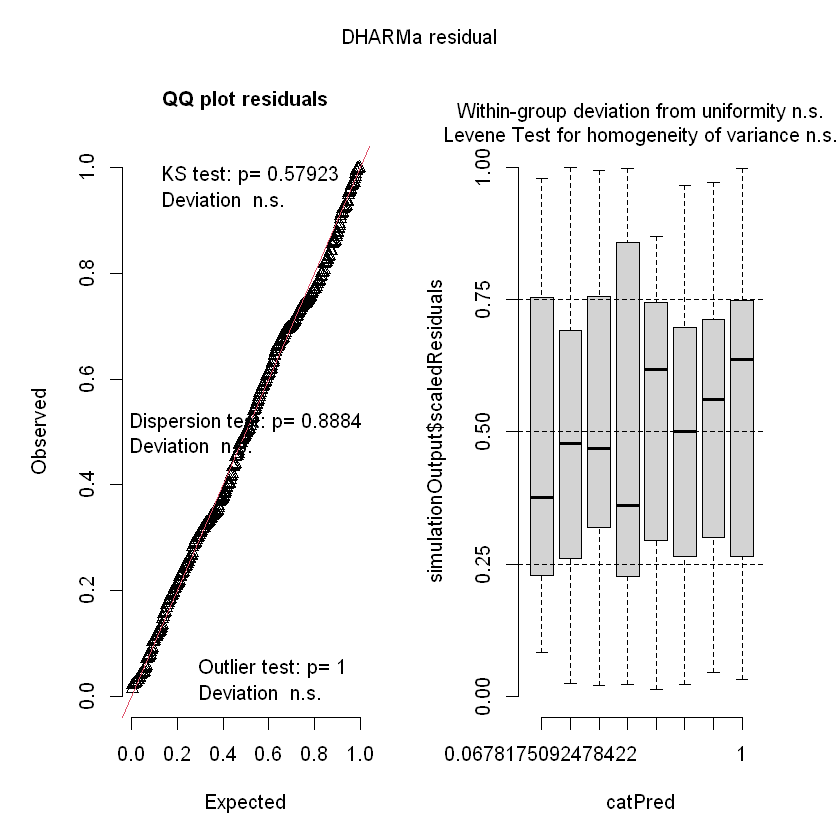

In [14]:
sim.amp <- simulateResiduals(model.glmmTMB.amp, n = 10000)
plot(sim.amp)

If this looks okay and nothing is red, we can proceed.

#### Estimated means for each group and timeperiod

In [15]:
em.amp <- emmeans(model.glmmTMB.amp, ~treatment*factor(dayperiod))
em.amp.df <- as.data.frame(em.amp)

#### Contrasts between groups at each time period

In [16]:
if ("dayperiod" %in% colnames(em.amp.df)) {
  timecol <- "dayperiod"
  timeperiods <- names(model_dayperiods)
} else if ("n_day" %in% colnames(em.amp.df)) {
  timecol <- "n_day"
  timeperiods <- model_days
} else {
  stop("No time column found in emmeans object")
}
contrast.grid <- generate_contrast_grid(model.glmmTMB.amp, em.amp.df, "treatment", treatments, timecol, timeperiods)

In [17]:
contr.amp <- contrast(em.amp, contrast.grid, adjust="holm")

### MESOR model

#### Model specification

In [18]:
model.glmmTMB.mesor <- glmmTMB(mesor ~ treatment*dayperiod + (dayperiod|animal_id), 
                               REML = T,
                               dispformula = ~treatment*dayperiod,
                               family = gaussian,
                               data = model_data)

#### Model diagnostics

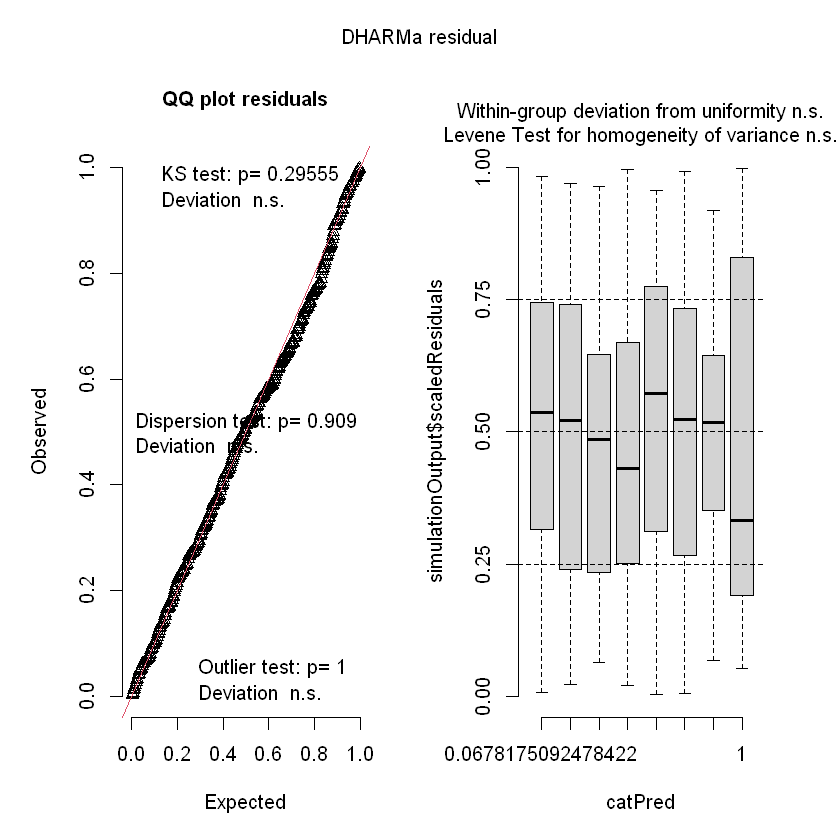

In [19]:
sim.mesor <- simulateResiduals(model.glmmTMB.mesor, n = 10000)
plot(sim.mesor)

If this looks okay and nothing is red, we can proceed.

#### Estimated means for each group and timeperiod

In [20]:
em.mesor <- emmeans(model.glmmTMB.mesor, ~treatment*factor(dayperiod))
em.mesor.df <- as.data.frame(em.mesor)

#### Contrasts between groups at each time period

In [21]:
if ("dayperiod" %in% colnames(em.mesor.df)) {
  timecol <- "dayperiod"
  timeperiods <- names(model_dayperiods)
} else if ("n_day" %in% colnames(em.mesor.df)) {
  timecol <- "n_day"
  timeperiods <- model_days
} else {
  stop("No time column found in emmeans object")
}
contrast.grid <- generate_contrast_grid(model.glmmTMB.amp, em.mesor.df, "treatment", treatments, timecol, timeperiods)

In [22]:
contr.mesor <- contrast(em.mesor, contrast.grid, adjust="holm", reverse=TRUE)

### Phase model

#### Phase correction

We have an additional step here. Our phase shift variable is in the `[-\pi, pi]` range. Our lights on is at \~06:00, which is ZT=0.

A sine without any phase shift:

1.  Starts at the MESOR value at ZT=0 (06:00),
2.  Climbs to a (positive) peak (zenith) at ZT=6 (12:00, noon),
3.  Falls down to the MESOR value again at ZT=12 (18:00, lights turn off),
4.  Falls down further and reaches its (negative) through (nadir) at ZT=18 (00:00, midnight),
5.  Climbs back to the MESOR value at ZT=24 (06:00), thereby completing its cycle.

Since rats are nocturnals, we expect that this will be the opposite, i.e. the expected sine wave of a rat's circadian activity should:

1.  Start at the MESOR value at ZT=0 (06:00),
2.  Fall to nadir at ZT=6 (12:00, noon),
3.  Climb back to MESOR at ZT=12 as the light period comes to an end (18:00, lights turn off),
4.  Climb further to zenith at ZT=18 (00:00, midnight),
5.  Fall back to MESOR as the dark period comes to an end, reaching MESOR again at ZT=24 (06:00, lights turn on), thereby completing its cycle.

Mathematically, this means that the sine has to shift by half a cycle, which is 12 hours, or `pi` radians. A shift by `pi` or `-pi` radians is the same (if you add or subtract 12 hours from midnight, you end up at noon either way), so we expect most phase shift values to be around `pi` or `-pi`. This means our distribution looks like this:

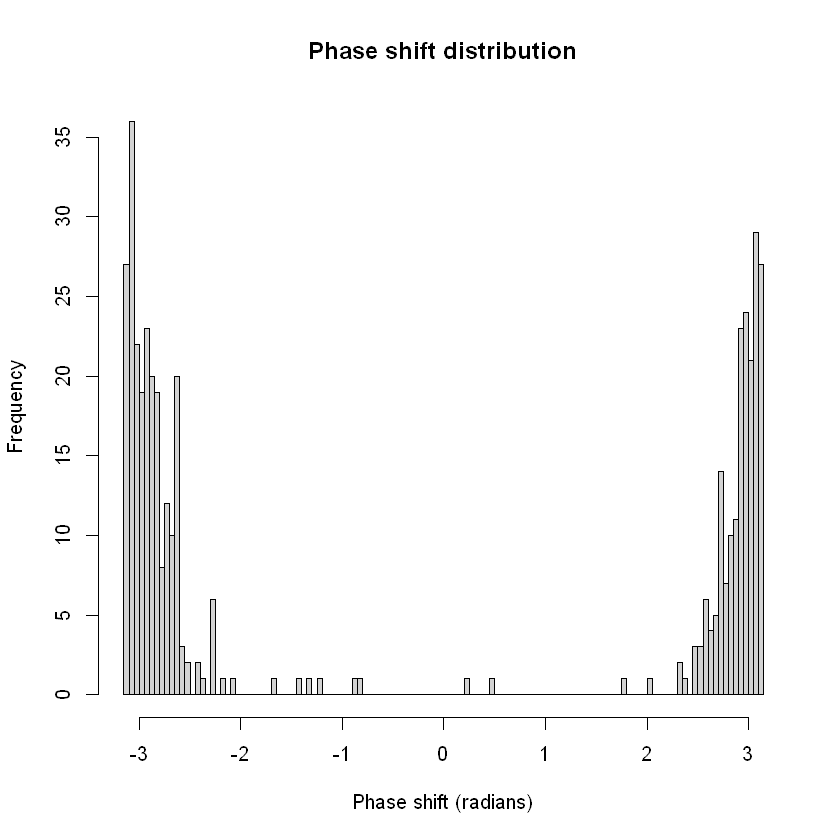

In [23]:
hist(model_data$phase, breaks=100, main="Phase shift distribution", xlab="Phase shift (radians)")

This is pretty difficult to model, so we apply a correction to put the values into a `[0, 2*pi]` range. We do this by adding `2*pi` to all negative phase values. An illustration of why this works is because a phase shift of `-0.9*pi` is the same as a phase shift of `1.1*pi`, while the positive phase shifts from 0 to pi need to remain the same.

This type of visual representation of the data is based on [the work by Hou et al., who have developed the `cosinoRmixedeffects` R package](https://doi.org/10.1186/s12859-021-04463-3).

In [24]:
model_data <- model_data %>%
  mutate(phase_corr = ifelse(phase < 0, 2*pi+phase, phase))

The resulting histogram looks much better in terms of similarity to commonly modelled distributions:

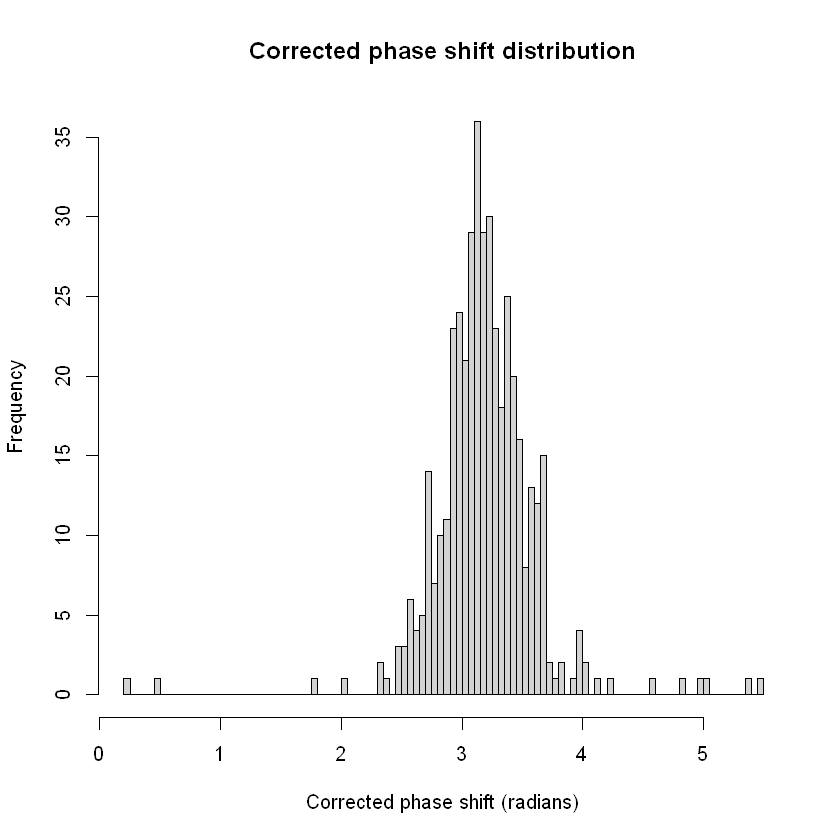

In [25]:
hist(model_data$phase_corr, breaks=100, main="Corrected phase shift distribution", xlab="Corrected phase shift (radians)")

#### Model specification

In [26]:
model.glmmTMB.phase <- glmmTMB(phase_corr ~ treatment*dayperiod + (1|animal_id), 
                               REML = T,
                               dispformula = ~treatment,
                               family = t_family,
                               data = model_data)

#### Model diagnostics

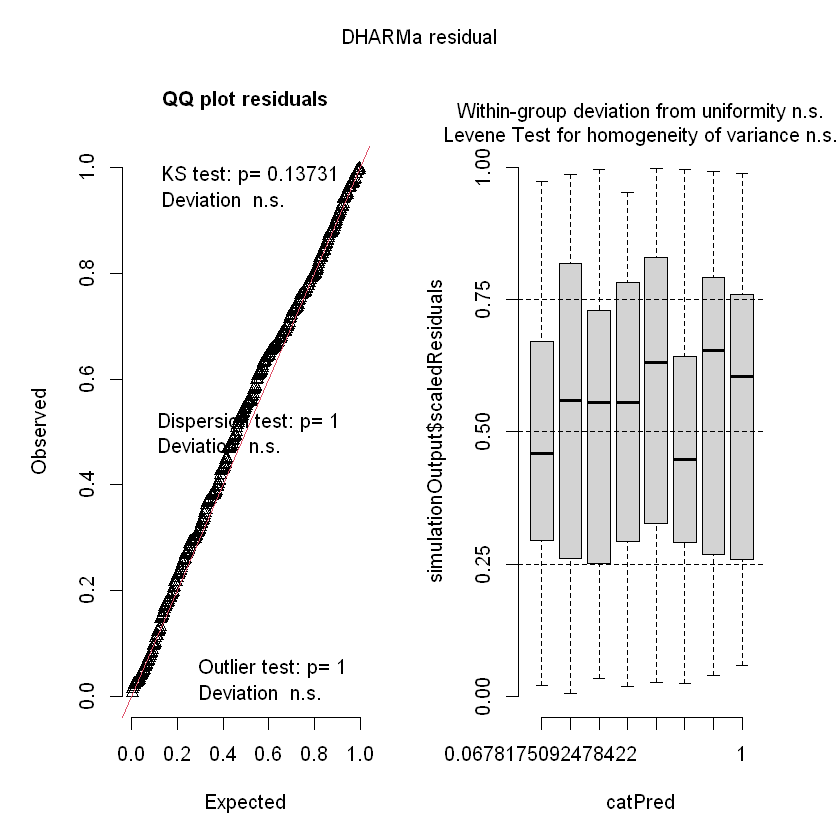

In [27]:
sim.phase <- simulateResiduals(model.glmmTMB.phase, n = 10000)
plot(sim.phase)

If this looks okay and nothing is red, we can proceed.

#### Estimated means for each group and timeperiod

In [28]:
em.phase <- emmeans(model.glmmTMB.phase, ~treatment*factor(dayperiod))
em.phase.df <- as.data.frame(em.phase)

#### Contrasts between groups at each time period

In [29]:
if ("dayperiod" %in% colnames(em.phase.df)) {
  timecol <- "dayperiod"
  timeperiods <- names(model_dayperiods)
} else if ("n_day" %in% colnames(em.phase.df)) {
  timecol <- "n_day"
  timeperiods <- model_days
} else {
  stop("No time column found in emmeans object")
}
contrast.grid <- generate_contrast_grid(model.glmmTMB.phase, em.phase.df, "treatment", treatments, timecol, timeperiods)

In [30]:
contr.phase <- contrast(em.phase, contrast.grid, adjust="holm")

#### Estimated zenith (peak activity) times for each group and timeperiod

To calculate zenith hours, we simply convert the phase shift output data from radians to hours.

In [31]:
em.peak_hour.df <- em.phase.df %>%
  select(c(treatment, dayperiod, emmean, asymp.LCL, asymp.UCL)) %>% 
  mutate_at(vars(emmean, asymp.LCL, asymp.UCL), phase_to_todpeak)
em.peak_hour.df <- em.peak_hour.df %>%
  mutate(across(c(emmean, asymp.LCL, asymp.UCL), ~ as_datetime(0) + dhours(.)))

## Plots

We will generate comparison plots between the groups for each time period.

Here, we can adjust figures' heights and widths.

In [32]:
fig.width <- 4.5
fig.height <- 5

In [33]:
plot_data <- data.frame(treatment=c(),
                        dayperiod=c(),
                        hour=c(),
                        pred_val=c(),
                        amplitude=c(),
                        mesor=c(),
                        phase=c(),
                        peak_hour=c())
for (dp in names(model_dayperiods)) {
  for (tr in treatments) {
#    vals <- sine_data.summary %>% filter(n_day == day) %>% filter(treatment == tr)
#    peak_hour <- 6-(vals$phase_mean*(24/(2*pi)))
#    if (peak_hour < 0) { peak_hour <- 24+peak_hour }
    amplitude <- em.amp.df %>% filter(treatment == tr, dayperiod == dp) %>% pull("emmean")
    mesor <- em.mesor.df %>% filter(treatment == tr, dayperiod == dp) %>% pull("emmean")
    phase <- em.phase.df %>% filter(treatment == tr, dayperiod == dp) %>% pull("emmean")
    peak_hour <- 6-(24*phase/(2*pi))
    if (peak_hour < 0) { peak_hour <- 24+peak_hour }
    hour <- seq(0,24,0.1)
    pred_val <- mesor+amplitude*sin((2*pi*hour/24)+phase)
    new_row <- data.frame(treatment=tr,
                          dayperiod=dp,
                          hour=hour,
                          pred_val=pred_val,
                          amplitude=amplitude,
                          mesor=mesor,
                          phase=phase,
                          peak_hour=peak_hour)
    plot_data <- rbind(plot_data, new_row)
  }
}

In [34]:
plots <- list()
dotplot_title_size <- 10
dotplot_axislab_size <- 9
simplot_margins <- c(0,0,0,0)
dotplot_margins <- c(3,0,0,0)
x_limits <- c(-1.5,24)
y_limits <- c(-0.8, 0.8)
mesor_location <- -1.5
for (dp in names(model_dayperiods)) {
  plot.summary_curve <- ggplot(plot_data %>% filter(dayperiod == dp), aes(x=hour, y=pred_val)) +
    #ggtitle(paste0("Reconstructed sine\n", dayperiod_labels[[dp]])) +
    ggtitle(dayperiod_labels[[dp]]) +
    scale_color_discrete(labels=c("Control", "STZ-icv"))+
    scale_x_continuous("ZT (hours)", breaks = seq(0,24,6), limits=x_limits)+
    ylim(y_limits)+
    geom_line(aes(color=treatment))+
    geom_hline(yintercept=0, linewidth=0.5, color="gray75")+
    labs(x="ZT (hours)", y="Activity")+
    geom_hline(aes(yintercept=mesor, color=treatment), linetype=2)+
    theme_bw()+
    theme(legend.position="top",
          legend.justification="left",
          legend.title=element_blank(),
          legend.margin=margin(c(0,0,0,0)),
          legend.spacing.x = unit(0, "mm"),
          legend.spacing.y = unit(0, "mm"),
          legend.box.margin=margin(0,0,-10,0),
          plot.margin = unit(simplot_margins, "mm"),
          plot.title = element_text(margin = margin(c(0,0,0,0))))+
    #theme(plot.title = element_text(size = 12),
    #      axis.title = element_text(size = 8))+
    geom_segment(aes(x = peak_hour, 
                     y = mesor+0.01, 
                     xend = peak_hour, 
                     yend = mesor+amplitude-0.01,
                     color = treatment),
                 arrow = arrow(length = unit(0.15, "cm"),ends="both"), 
                 linewidth=0.5, linetype=1)+
    geom_segment(aes(x = 24, 
                     y =  mesor+amplitude,
                     xend = peak_hour+0.1, 
                     yend = mesor+amplitude,
                     color = treatment),
                 #color = "gray50")
                 arrow = arrow(length = unit(0.15, "cm")), linewidth=0.5, linetype=1)+
    geom_segment(aes(x = mesor_location, 
                     y =  0,
                     xend = mesor_location, 
                     yend = mesor,
                     color = treatment),
                 #color = "gray50")
                 arrow = arrow(length = unit(0.15, "cm")), linewidth=0.5, linetype=1)
  
  plot.amp <- ggplot(em.amp.df %>% filter(dayperiod == dp), aes(x=treatment, y=emmean, color=treatment, group=treatment))+
    geom_point(stat="identity")+
    geom_errorbar(stat="identity", aes(ymin=lower.CL, ymax=upper.CL), width=0.08)+
    labs(x="", y="Mean \u00B1 CI (95%)") + 
    theme_bw() +
    theme(strip.background = element_blank(),
          strip.placement = "outside",
          legend.position = "none",
          plot.title = element_text(size = dotplot_title_size),
          axis.title=element_text(size = dotplot_axislab_size),
          plot.margin = unit(dotplot_margins, "mm"),
          #axis.title.y = element_text(margin = margin(0,-1000,0,0)),
          axis.text.x = element_text(angle=45, hjust=1))+
    ggtitle("Amplitude")
  
  plot.mesor <- ggplot(em.mesor.df %>% filter(dayperiod == dp), aes(x=treatment, y=emmean, color=treatment, group=treatment))+
    geom_point(stat="identity")+
    geom_errorbar(stat="identity", aes(ymin=lower.CL, ymax=upper.CL), width=0.08)+
    labs(x="", y="") + 
    theme_bw() +
    theme(strip.background = element_blank(),
          strip.placement = "outside",
          legend.position = "none",
          plot.title = element_text(size = dotplot_title_size),
          axis.title=element_text(size = dotplot_axislab_size),
          plot.margin = unit(dotplot_margins, "mm"))+
    theme(axis.text.x = element_text(angle=45, hjust=1))+
    ggtitle("Midline")
  
  plot.peak_hour <- ggplot(em.peak_hour.df %>% filter(dayperiod == dp), aes(x=treatment, y=emmean, color=treatment, group=treatment))+
    geom_point(stat="identity")+
    geom_errorbar(stat="identity", aes(ymin=asymp.LCL, ymax=asymp.UCL), width=0.08)+
    labs(x="", y="") + 
    scale_y_datetime(date_labels = "%H:%M") +
    theme_bw() +
    theme(strip.background = element_blank(),
          strip.placement = "outside",
          legend.position = "none",
          plot.title = element_text(size = dotplot_title_size),
          axis.title=element_text(size = dotplot_axislab_size),
          plot.margin = unit(dotplot_margins, "mm"))+
    theme(axis.text.x = element_text(angle=45, hjust=1))+
    ggtitle("Zenith")  
  
  plots[[dp]] <- (plot.summary_curve / (plot.amp | plot.mesor | plot.peak_hour)) +
    plot_layout(heights = c(3,2))
}

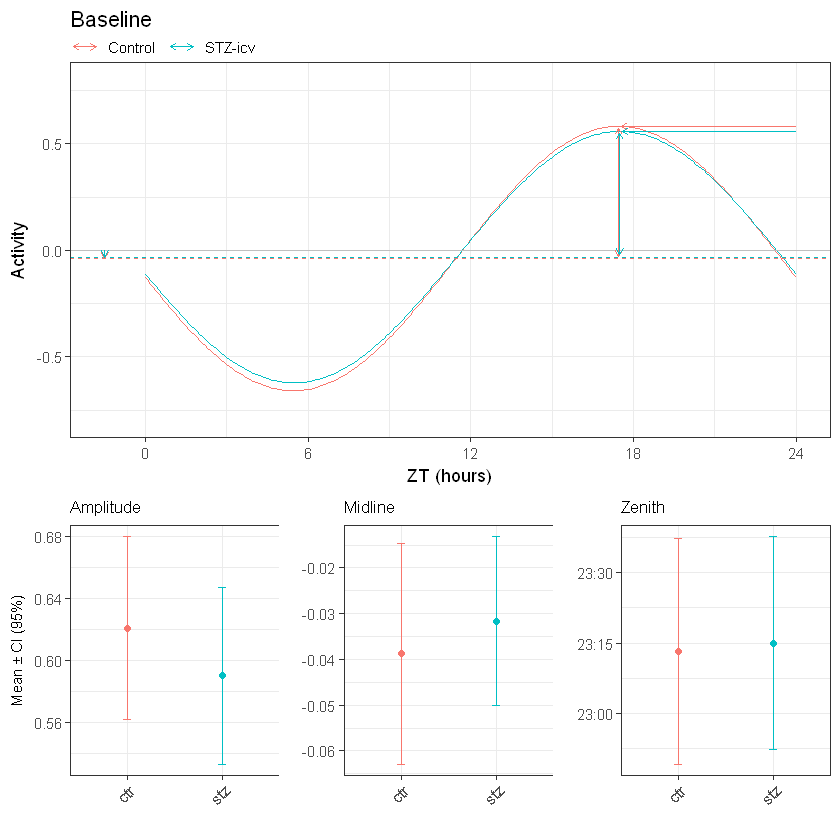

In [35]:
plots[["baseline"]]

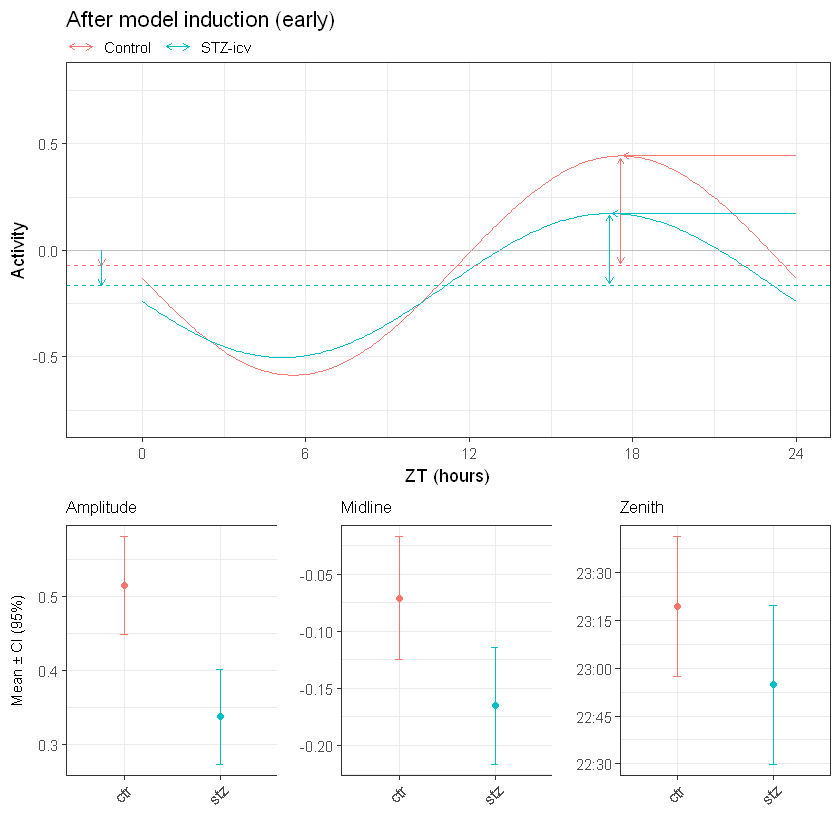

In [36]:
plots[["after_stz"]]

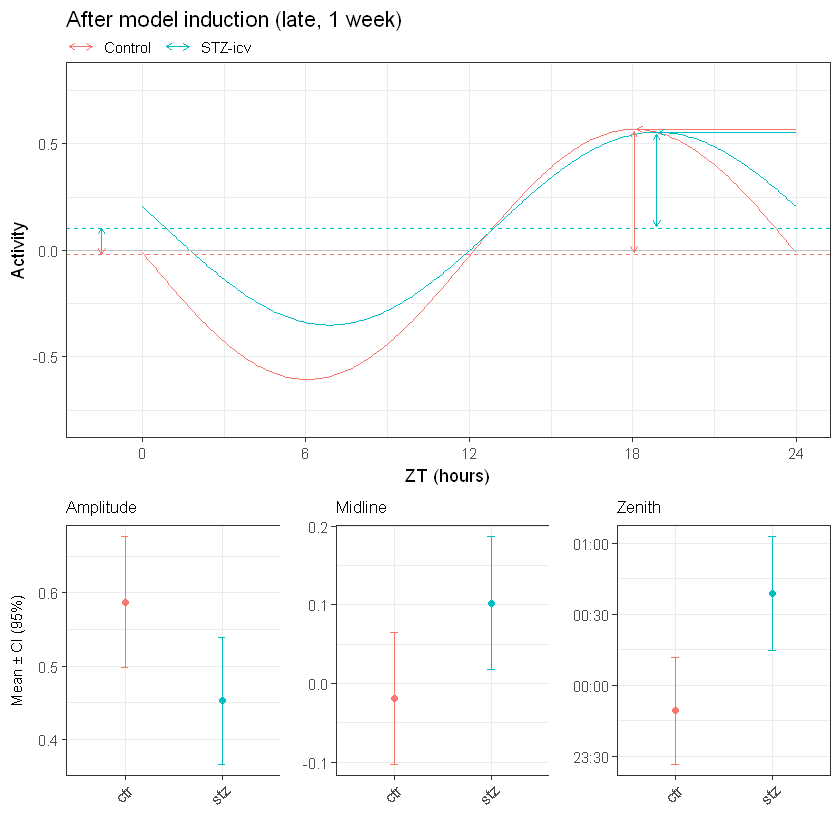

In [37]:
plots[["before_beh"]]

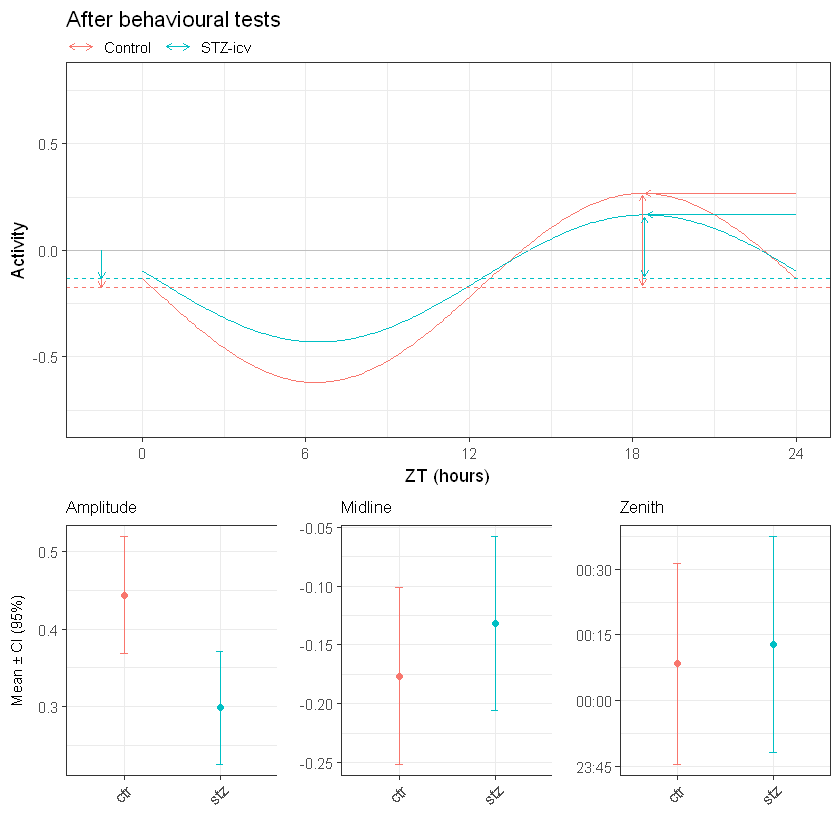

In [38]:
plots[["after_beh"]]

In [39]:
left_col <- wrap_plots(plots[["baseline"]], plot_spacer(), plots[["before_beh"]], ncol=1) + plot_layout(heights = c(1, 0.01, 1))
#top_row <- top_row + plot_annotation(theme = theme(plot.margin = margin(0,2,0,0, "cm")))
right_col <- wrap_plots(plots[["after_stz"]], plot_spacer(), plots[["after_beh"]], ncol=1) + plot_layout(heights = c(1, 0.01, 1))
full_grid <- wrap_plots(left_col, plot_spacer(), right_col, ncol=3) + plot_layout(widths = c(1, 0.01, 1))# + plot_annotation(tag_levels = 'A')
ggsave("3_outputs_R/3-2_StatistiSLAV.png", plot=full_grid, width=7.55, height=10, dpi=600)

In [40]:
contr.amp.df <- data.frame(contr.amp)
c.a <- left_join(contr.amp.df, data.frame(confint(contr.amp)), by=c("contrast", "estimate", "SE", "df"))
contr.mesor.df <- data.frame(contr.mesor)
c.m <- left_join(contr.mesor.df, data.frame(confint(contr.mesor)), by=c("contrast", "estimate", "SE", "df"))
contr.phase.df <- data.frame(contr.phase)
c.p <- left_join(contr.phase.df, data.frame(confint(contr.phase)), by=c("contrast", "estimate", "SE", "df"))
library(writexl)
write_xlsx(list("Amplitude" = c.a,
                "Midline" = c.m,
                "Phase" = c.p),
           "3_outputs_R/3-2_StatistiSLAV_contrasts.xlsx")